In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: #797D7F30 !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import sys

---
Analyse data
---

In [4]:
data_pd = pd.read_csv('./data/raw_data.txt', sep=r'\s+', header=None)
data_pd.columns = ['m1', 'm2', 'x', 'theta', 'P1', 'P2']

In [5]:
data_pd

,m1,m2,x,theta,P1,P2
0,1.0,1.5,-0.01,0.0,0.12349,0.12349
1,1.0,1.5,-0.01,30.0,0.11634,0.08993
2,1.0,1.5,-0.01,60.0,0.09855,0.02890
3,1.0,1.5,-0.01,90.0,0.07791,0.00028
4,1.0,1.5,-0.01,120.0,0.06095,0.01244
...,...,...,...,...,...,...
751,1.5,1.7,-0.09,60.0,2.18423,1.40168
752,1.5,1.7,-0.09,90.0,0.91968,0.32984
753,1.5,1.7,-0.09,120.0,0.31187,0.07966
754,1.5,1.7,-0.09,150.0,0.17554,0.12959


In [6]:
print('m1 :', set(data_pd['m1']))
print('m2 :', set(data_pd['m2']))
print(' x :', set(data_pd['x']))
print(' t :', set(data_pd['theta']))

m1 : {0.9, 1.0, 0.6, 0.8, 0.7, 1.1, 1.2, 1.3, 1.4, 1.5}
m2 : {1.7, 1.5, 1.6}
 x : {-0.05, -0.03, -0.06, -0.07, -0.08, -0.09, -0.1, -0.02, -0.04, -0.01}
 t : {0.0, 180.0, 150.0, 120.0, 90.0, 60.0, 30.0}


/home/denis/anaconda3/envs/torch_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


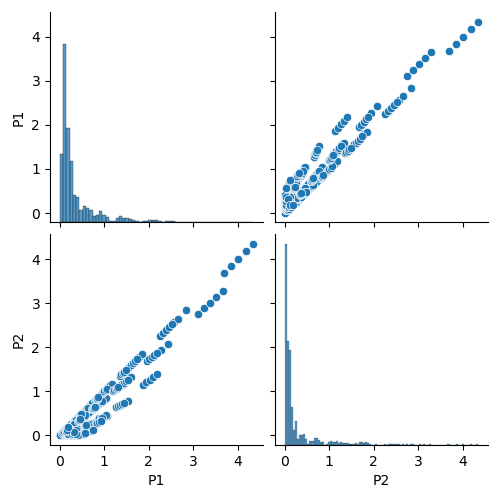

In [7]:
sns.pairplot(data_pd, vars=['P1', 'P2'])

<Axes: xlabel='P1', ylabel='P2'>

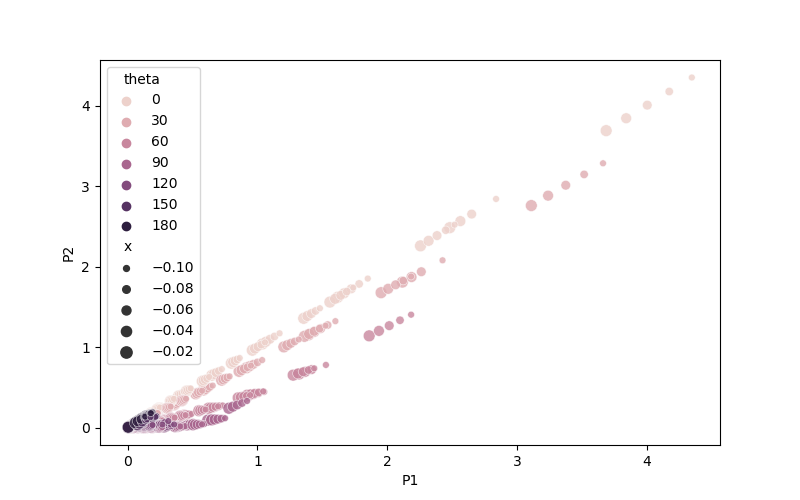

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data_pd, x='P1', y='P2', hue='theta', size='x', alpha=0.8)

---
Dataload
---

In [9]:
import torch
from sklearn.model_selection import train_test_split

from torch import tensor, cat
from torch.utils.data import Dataset

In [10]:
class Normalistor():
    def __init__(self, pd_data):
        tensor_data = tensor(np.array(pd_data, dtype=np.float32))
        self.norm_means = cat([tensor_data[:, 0:4].mean(axis=0), torch.zeros(2)])
        self.norm_stds = cat([tensor_data[:, 0:4].std(axis=0), torch.ones(2)])
        self.tensor_norm = self.normalise(tensor_data)
    
    def get_normalised_tensor(self):
        return self.tensor_norm

    def normalise(self, tensor):
        if tensor.shape[1] == 6:
            return (tensor - self.norm_means) / self.norm_stds
        if tensor.shape[1] == 4:
            return (tensor - self.norm_means[:, 0:4]) / self.norm_stds[:, 0:4]
        else:
            raise ValueError()

    def denormalise(self, tensor):
        if tensor.shape[1] == 6:
            return tensor * self.norm_stds + self.norm_means
        if tensor.shape[1] == 4:
            return tensor * self.norm_stds[:, 0:4] + self.norm_means[0, 0:4]
        else:
            raise ValueError()


class MyDataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)
    
    def __getitem__(self, idx):
        row = self.tensor[idx]
        return row[0:4], row[4:6]

    def get_x(self):
        return self.tensor[:, 0:4]
    
    def get_y(self):
        return self.tensor[:, 4:6]

In [11]:
normalistion = Normalistor(data_pd)
norm_datas_tensor = normalistion.get_normalised_tensor()

In [12]:
train_tensor, test_tensor = train_test_split(norm_datas_tensor, test_size=0.20)
train_dataset = MyDataset(train_tensor)
test_dataset = MyDataset(test_tensor)

---
Model
---

In [13]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.seq = torch.nn.Sequential(
            torch.nn.Linear(4, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.seq(x)

In [21]:
if 'model' in locals():
    del model
gc.collect()

2450

---
Learning
---

In [22]:
model = SimpleNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
model_loss = torch.nn.MSELoss()

In [23]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

In [24]:
epochs = 50

running_loss = []
test_loss = []

traits = test_dataset.get_x()
targets = test_dataset.get_y()
result = model(traits)
test_loss.append(model_loss(targets, result).item())
print('test loss = ', test_loss[-1])


for epo in range(epochs):
    print(f'inside epoch {epo+1:>3}', end=' ############### \n')
    model.train()

    i = 0 
    for traits, targets in train_loader:
        i += 1
        evaluated = model(traits)
        loss = model_loss(evaluated, targets)

        running_loss.append(loss.item())
        sys.stdout.write(f'{i} -- {loss.item()}\r')
        sys.stdout.flush()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    traits = test_dataset.get_x()
    targets = test_dataset.get_y()
    result = model(traits)
    test_loss.append(model_loss(targets, result).item())
    print('test loss = ', test_loss[-1])

    scheduler.step()
    model.eval()

test loss =  0.44374173879623413
inside epoch   1 ############### 
test loss =  0.3006478250026703
inside epoch   2 ############### 
test loss =  0.22146634757518768
inside epoch   3 ############### 
test loss =  0.19466982781887054
inside epoch   4 ############### 
test loss =  0.17137303948402405
inside epoch   5 ############### 
test loss =  0.16063815355300903
inside epoch   6 ############### 
test loss =  0.15077762305736542
inside epoch   7 ############### 
test loss = 02338829636574 0.14609795808792114
inside epoch   8 ############### 
test loss =  0.141285702586174
inside epoch   9 ############### 
test loss = 2919831275948 0.13923616707324982
inside epoch  10 ############### 
test loss =  0.1370466947555542
inside epoch  11 ############### 
test loss =  0.13599298894405365
inside epoch  12 ############### 
test loss =  0.13494431972503662
inside epoch  13 ############### 
test loss =  0.13440273702144623
inside epoch  14 ############### 
test loss =  0.13391101360321045
inside

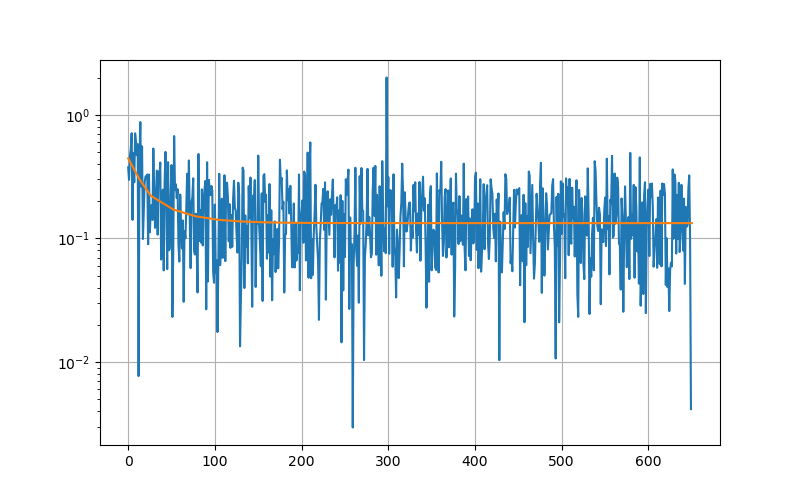

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(running_loss)
plt.plot([(i) * len(running_loss) / (len(test_loss)-1) for i in range(len(test_loss))], test_loss)
plt.yscale('log')
plt.grid()

In [26]:
torch.save(model.state_dict(), './models/SimpleModel_01.pth')